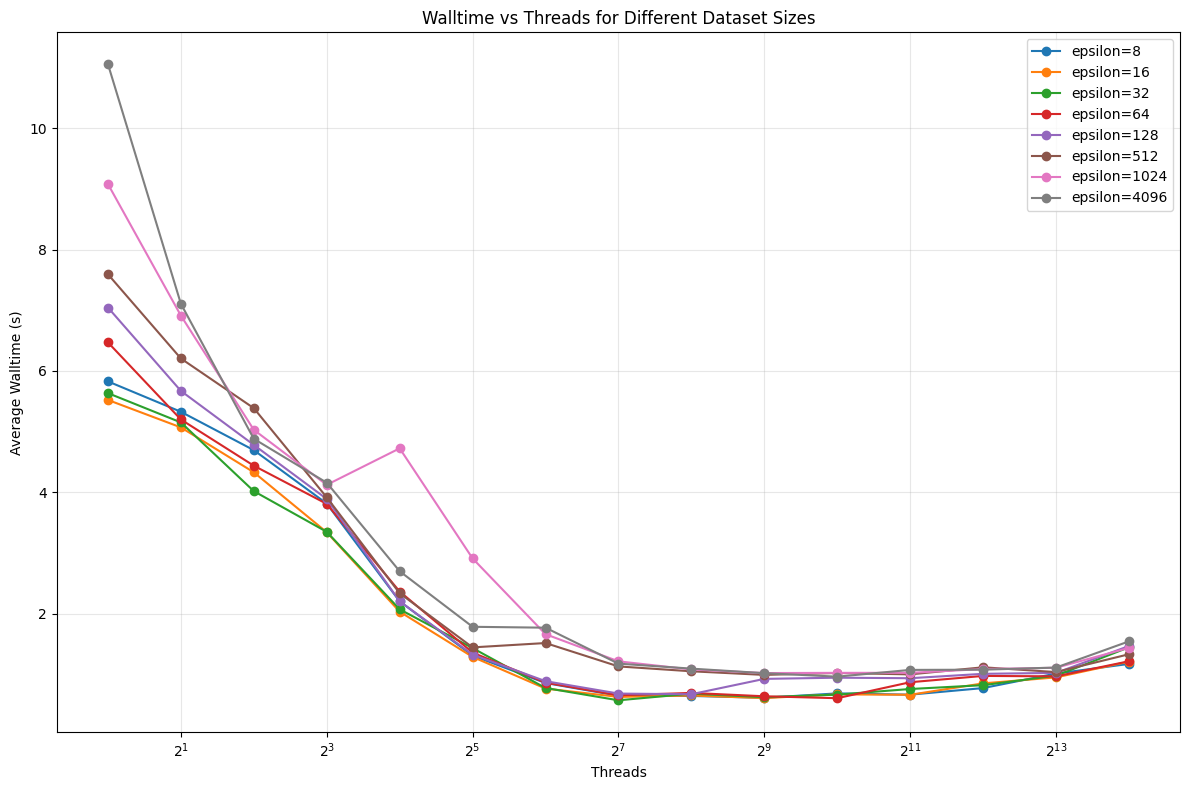

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob

def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    df = pd.read_csv(file_path)
    return df['threads'], df['avg_walltime_s']

# 文件名模式
file_patterns = ['8_falcon_multithread.csv', '16_falcon_multithread.csv', '32_falcon_multithread.csv',
                 '64_falcon_multithread.csv', '128_falcon_multithread.csv', '512_falcon_multithread.csv',
                 '1024_falcon_multithread.csv', '4096_falcon_multithread.csv']

# 创建图表
plt.figure(figsize=(12, 8))

# 为每个文件绘制一条线
for file_pattern in file_patterns:
    try:
        # 提取文件前缀作为标签
        label = file_pattern.split('_')[0]
        threads, avg_walltime_s = load_data(file_pattern)
        plt.plot(threads, avg_walltime_s, marker='o', label=f'epsilon={label}')
    except FileNotFoundError:
        print(f"文件 {file_pattern} 未找到，跳过")
        continue

# 设置图表属性
plt.xlabel('Threads')
plt.ylabel('Average Walltime (s)')
plt.title('Walltime vs Threads for Different Dataset Sizes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)  # 使用对数刻度，基数为2
# plt.yscale('log', base=10)  # 使用对数刻度

# 显示图表
plt.tight_layout()
plt.show()

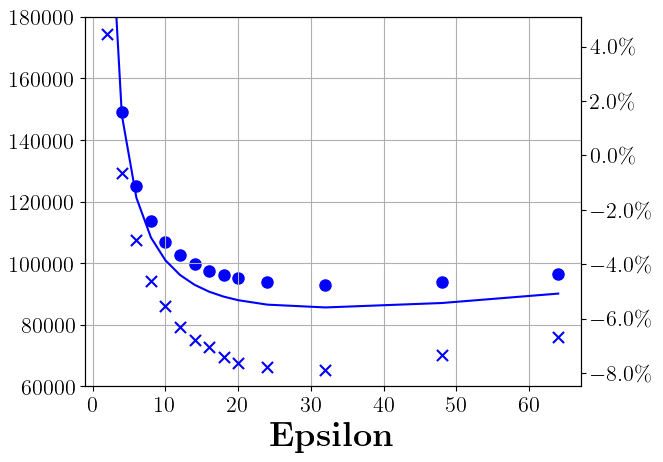

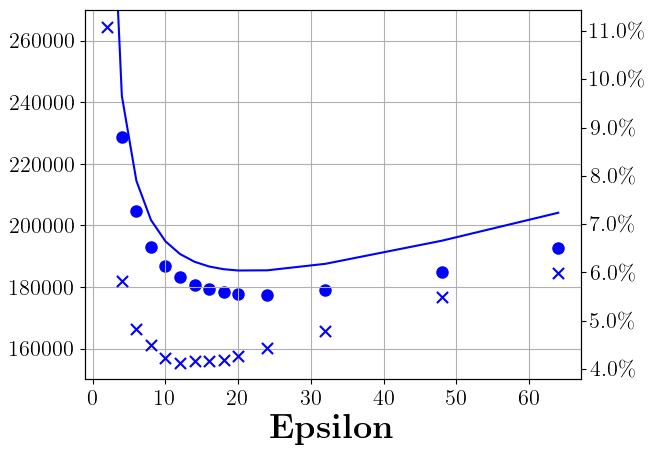

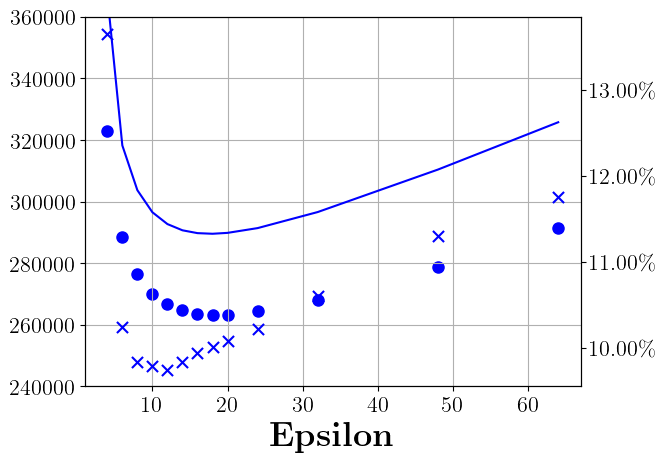

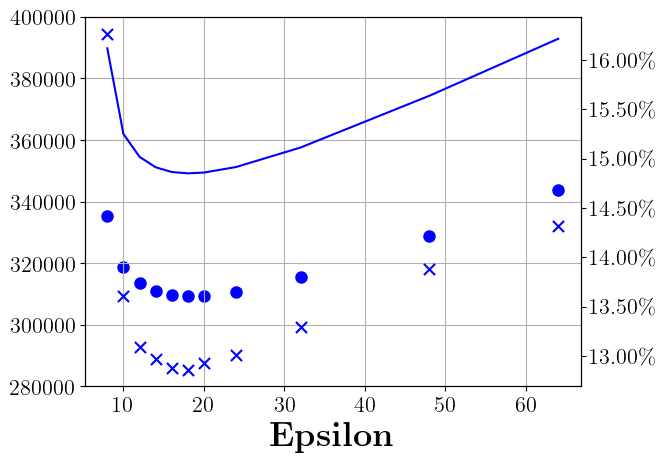

In [7]:
from matplotlib.ticker import PercentFormatter
import numpy as np

LOG_PATH = "/mnt/home/zwshi/learned-index/cost-model/visualize/data/log/"

def load_data(file_path,max_eps=64):
    df = pd.read_csv(file_path)
    grouped = df.groupby('epsilon', as_index=False)['avg_IOs'].mean()
    grouped = grouped.rename(columns={'avg_IOs': 'real'})
    grouped = grouped[grouped["epsilon"]<=max_eps] 
    return grouped

def load_log(file_path, M=20, query_nums=1e6):
    df = pd.read_csv(file_path)
    df = df[df['M'] == M]
    grouped = df.groupby('epsilon', as_index=False)['cost'].mean()
    grouped['expected'] = grouped['cost'] * query_nums
    return grouped[['epsilon', 'expected']]

def prepare_merged(file_path, log_file_path, M=20, query_nums=1e6):
    real_df = load_data(file_path)
    exp_df  = load_log(log_file_path, M, query_nums)
    merged = pd.merge(real_df, exp_df, on='epsilon', how='inner').sort_values('epsilon')
    merged['rel_err'] = (merged['expected'] - merged['real']) / merged['real']
    return merged

# === 新增：预计算全局 y 轴范围（左轴：IO；右轴：相对误差%）===
def compute_global_limits(tasks, log_file_path, query_nums=1e6, max_eps=64, pad_ratio=0.05):
    """
    tasks: [(csv_path, M), (csv_path, M), ...]
    返回： (y_io_min, y_io_max), (y_err_min_pct, y_err_max_pct)
    """
    io_min, io_max = float('inf'), float('-inf')
    err_min, err_max = float('inf'), float('-inf')
    for csv_path, M in tasks:
        merged = prepare_merged(csv_path, log_file_path, M, query_nums)
        if len(merged)==0: 
            continue
        # 左轴：真实/预测 IO
        cur_min = min(merged['real'].min(), merged['expected'].min())
        cur_max = max(merged['real'].max(), merged['expected'].max())
        io_min = min(io_min, cur_min)
        io_max = max(io_max, cur_max)
        # 右轴：相对误差（转百分比）
        cur_e_min = (merged['rel_err']*100).min()
        cur_e_max = (merged['rel_err']*100).max()
        err_min = min(err_min, cur_e_min)
        err_max = max(err_max, cur_e_max)
    # 加一点边距，避免顶边
    io_pad  = (io_max-io_min)*pad_ratio if np.isfinite(io_min) and np.isfinite(io_max) else 0
    err_pad = (err_max-err_min)*pad_ratio if np.isfinite(err_min) and np.isfinite(err_max) else 0
    return (io_min-io_pad, io_max+io_pad), (err_min-err_pad, err_max+err_pad)

def plot_data(file_path, log_file_path, M=20, query_nums=1e6,
              y_io_lim=None, y_err_lim_pct=None):
    merged = prepare_merged(file_path, log_file_path, M, query_nums)
    fig, ax = plt.subplots()
    ax.scatter(merged['epsilon'], merged['real'], marker='o', label=r'\textbf{\Large{real IOs}}',color="blue")
    ax.plot(merged['epsilon'], merged['expected'], linestyle="-", label=r'\textbf{\Large{expected IOs}}',color="blue")

    ax.set_xlabel(r'\textbf{\Huge{Epsilon}}')
    # ax.set_ylabel(r'\textbf{\Huge{Average IOs}}')
    # ax.set_title(f'M={M}MB')
    ax.grid(True)

    # 统一左轴范围
    if y_io_lim is not None:
        ax.set_ylim(*y_io_lim)

    ax2 = ax.twinx()
    ax2.scatter(merged['epsilon'], merged['rel_err'] * 100.0, label=r'\textbf{\Large{Relative error}}', marker='x',color="blue")      
    # ax2.set_ylabel(r'\textbf{\Huge{Relative error}}')
    ax2.yaxis.set_major_formatter(PercentFormatter())

    # 统一右轴范围（百分比）
    if y_err_lim_pct is not None:
        ax2.set_ylim(*y_err_lim_pct)

    # 合并图例（可选）
    # lines, labels = ax.get_legend_handles_labels()
    # lines2, labels2 = ax2.get_legend_handles_labels()
    # ax.legend(lines + lines2, labels + labels2, loc='best')
    
    plt.savefig(f"books_{M}MB_IOs_prediction.pdf", dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close(fig)

# ===== 用法：先算全局范围，再按同一范围出图 =====
tasks = [
    ('books_10M_M40_falcon.csv', 40),
    ('books_10M_M20_falcon.csv', 20),
    ('books_10M_M10_falcon.csv', 10),
]
# y_io_lim, y_err_lim_pct = compute_global_limits(tasks, LOG_PATH + 'books_10M_uint64_unique.query.log')

plot_data('books_10M_M60_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log', 60, y_io_lim=(60000,180000))

plot_data('books_10M_M40_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log', 40, y_io_lim=(150000,270000))

plot_data('books_10M_M20_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log', 20, y_io_lim=(240000,360000))

plot_data('books_10M_M10_falcon.csv',LOG_PATH + 'books_10M_uint64_unique.query.log', 10, y_io_lim=(280000,400000))





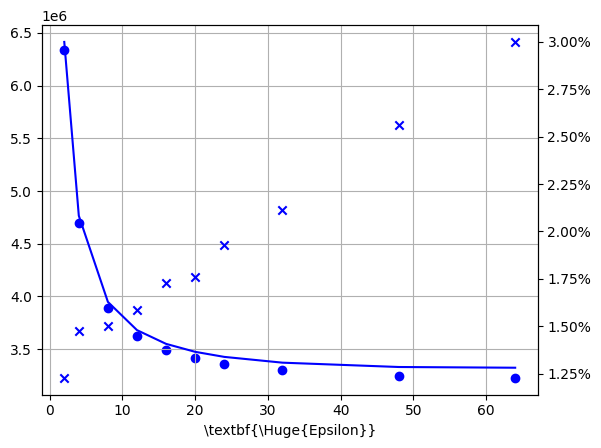

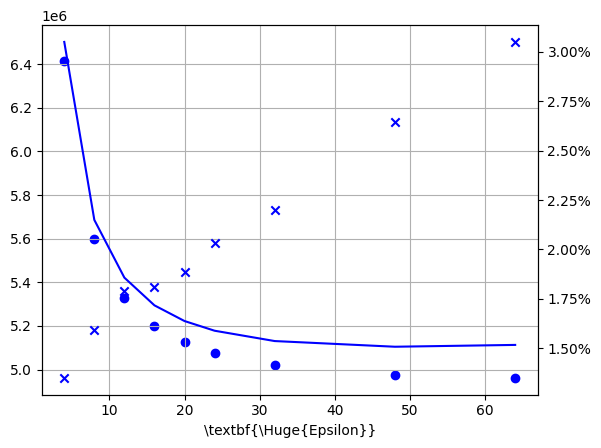

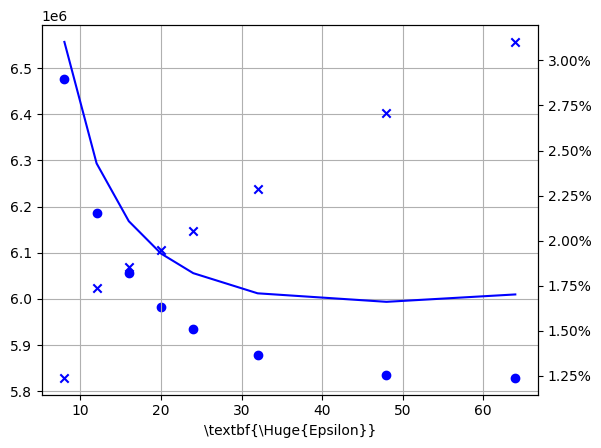

In [4]:
plot_data('range_fb_10M_M40.csv', LOG_PATH + 'range_query_1M_uu.log',40)
plt.show()
plot_data('range_fb_10M_M20.csv', LOG_PATH + 'range_query_1M_uu.log',20)
plt.show()
plot_data('range_fb_10M_M10.csv', LOG_PATH + 'range_query_1M_uu.log',10)
plt.show()

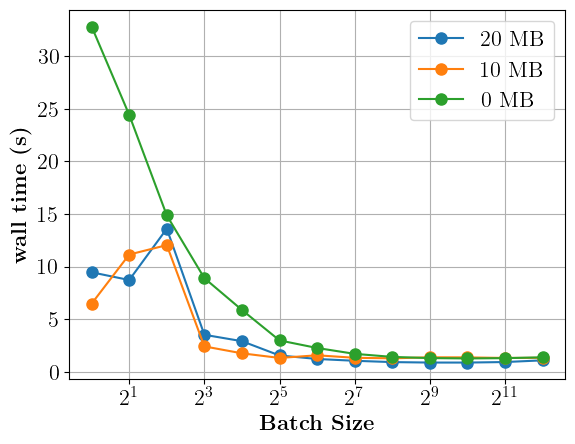

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['text.usetex'] = True
plt.rcParams['lines.markersize'] = 8 
plt.rcParams['font.size'] = 16

def load_data(file_path):
    df = pd.read_csv(file_path)
    grouped = df.groupby('batch', as_index=False)['avg_walltime_s'].mean()
    return grouped 

def plot_data(file_paths,M):
    """绘图：左轴=真实/预测 IOs，右轴=相对误差(%)"""
    fig, ax = plt.subplots()
    # 左轴：真实值与预测值
    for i,file_path in enumerate(file_paths):
        data = load_data(file_path)
        ax.plot(data['batch'], data['avg_walltime_s'], marker='o', label=f'{M[i]} MB')

    ax.set_xlabel(r'\textbf{Batch Size}')
    ax.set_ylabel(r'\textbf{wall time (s)}')
    # ax.set_xscale('log')
    plt.xscale('log', base=2)
    # ax.set_title(f'Epsilon vs Average IOs (M={M}MB)')
    ax.grid(True)


    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    plt.savefig('batch_falcon.pdf', bbox_inches="tight", dpi=300)

# print(load_data('batch_falcon.csv'))
plot_data(['20M_batch_falcon.csv','10M_batch_falcon.csv','0M_batch_falcon.csv'],[20,10,0])